In [1]:
import torch
import pickle
import einops
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import Normalize
from typing import Callable
import json

import circuits.analysis as analysis
import circuits.eval_sae_as_classifier as eval_sae
import circuits.chess_utils as chess_utils
import circuits.utils as utils
import circuits.f1_analysis as f1_analysis

/Users/rangell/miniconda3/envs/sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I've been trying to balance: Having a notebook that's easy to play around with, but also modularizing code into files, and not having duplicated functions between notebooks and python files that goes stale.

Here's what I'm trying: All of the following functions in the next few cells are also in `f1_analysis.py`. By default, this notebook just loads a `f1_results.csv` from the autoencoder group path, automatically generated during `full_pipeline.ipynb`. If you want to play around with new analysis functions, feel free to uncomment the lines that call these functions, modify the below functions, and experiment to your heart's content.

In [2]:
def mask_all_blanks(results: dict, device) -> dict:
    custom_functions = analysis.get_all_custom_functions(results)
    for function in custom_functions:
        function_name = function.__name__

        if function == chess_utils.board_to_piece_state or function == chess_utils.board_to_piece_color_state:
            on_TFRRC = results[function_name]['on']
            off_TFRRC = results[function_name]['off']
            results[function_name]['on'] = analysis.mask_initial_board_state(on_TFRRC, function, device)
            results[function_name]['off'] = analysis.mask_initial_board_state(off_TFRRC, function, device)

    return results

def best_f1_average(f1_TFRRC: torch.Tensor, config: chess_utils.Config) -> torch.Tensor:
    """For every threshold, for every square, find the best F1 score across all features. Then average across all squares.
    NOTE: If the function is binary, num_squares == 1. If it is board to piece state, num_squares == 8 * 8 * 12"""
    f1_TRRC, _ = torch.max(f1_TFRRC, dim=1)

    T, R1, R2, C = f1_TRRC.shape

    if config.one_hot_mask_idx is not None:
        C -= 1

    max_possible = R1 * R2 * C

    f1_T = einops.reduce(f1_TRRC, 'T R1 R2 C -> T', 'sum') / max_possible

    return f1_T
    

def f1s_above_threshold(f1_TFRRC: torch.Tensor, threshold: float, config: chess_utils.Config) -> tuple[torch.Tensor, torch.Tensor]:
    """For every threshold, for every square, find the best F1 score across all features. Then, find the number of squares that have a F1 score above the threshold.
    If the function is binary, num_squares == 1. If it is board to piece state, num_squares == 8 * 8 * 12
    NOTE: This will probably be most useful for features with 8x8xn options."""
    f1_TRRC, _ = torch.max(f1_TFRRC, dim=1)

    f1s_above_threshold_TRCC = f1_TRRC > threshold

    T, R1, R2, C = f1_TRRC.shape
    if config.one_hot_mask_idx is not None:
        C -= 1

    max_possible = R1 * R2 * C

    f1_T = einops.reduce(f1s_above_threshold_TRCC, 'T R1 R2 C -> T', 'sum')

    f1_T_normalized = f1_T / max_possible

    return f1_T, f1_T_normalized


In [3]:
importlib.reload(analysis)


def get_custom_functions(
    autoencoder_group_path: str, results_filename_filter: str, device: str
) -> list[Callable]:
    folders = eval_sae.get_nested_folders(autoencoder_group_path)
    first_autoencoder_path = folders[0]
    results_filenames = analysis.get_all_results_file_names(
        first_autoencoder_path, results_filename_filter
    )

    if len(results_filenames) > 1 or len(results_filenames) == 0:
        raise ValueError("There are multiple results files")
    results_filename = results_filenames[0]

    with open(first_autoencoder_path + results_filename, "rb") as f:
        results = pickle.load(f)

    results = utils.to_device(results, device)

    custom_functions = analysis.get_all_custom_functions(results)
    return custom_functions


def get_custom_function_names(custom_functions: list[Callable]) -> list[str]:
    custom_function_names = [function.__name__ for function in custom_functions]
    return custom_function_names

def get_threshold_column_names(func_name: str, threshold: float) -> tuple[str, str]:
    return (f"{func_name}_f1_threshold_{threshold}", f"{func_name}_f1_threshold_{threshold}_normalized")


def get_all_sae_f1_results(
    autoencoder_group_paths: list[str],
    df: pd.DataFrame,
    results_filename_filter: str,
    custom_functions: list[Callable],
    custom_function_names: list[str],
    device: str,
    thresholds: list[float],
    mask: bool,
) -> dict:
    all_sae_results = {}

    for autoencoder_group_path in autoencoder_group_paths:

        folders = eval_sae.get_nested_folders(autoencoder_group_path)
        sae_results = {}

        for autoencoder_path in folders:

            print(f"Processing {autoencoder_path}")

            assert (
                autoencoder_path in df["autoencoder_path"].values
            ), f"{autoencoder_path} not in csv file"

            sae_results[autoencoder_path] = {}

            results_filenames = analysis.get_all_results_file_names(
                autoencoder_path, results_filename_filter
            )
            if len(results_filenames) > 1 or len(results_filenames) == 0:
                print(
                    f"Skipping {autoencoder_path} because it has {len(results_filenames)} results files"
                )
                print("This is most likely because there are results files from different n_inputs")
                continue
            results_filename = results_filenames[0]

            with open(autoencoder_path + results_filename, "rb") as f:
                results = pickle.load(f)

            results = utils.to_device(results, device)

            results = analysis.add_off_tracker(results, custom_functions, device)
            f1_dict_TFRRC = analysis.get_all_f1s(results, device)

            # feature_labels = analysis.analyze_results_dict(
            #     results,
            #     output_path="",
            #     device=device,
            #     high_threshold=0.95,
            #     low_threshold=0.1,
            #     significance_threshold=10,
            #     save_results=False,
            #     mask=mask,
            #     verbose=False,
            #     print_results=False,
            # )

            correct_row = df["autoencoder_path"] == autoencoder_path
            sae_results[autoencoder_path]["l0"] = df[correct_row]["l0"].values[0]
            sae_results[autoencoder_path]["frac_variance_explained"] = df[correct_row][
                "frac_variance_explained"
            ].values[0]

            for func_name in f1_dict_TFRRC:
                config = chess_utils.config_lookup[func_name]
                custom_function = config.custom_board_state_function
                assert (
                    custom_function in custom_functions
                ), f"Key {custom_function} not in custom_functions"
                f1_TFRRC = f1_dict_TFRRC[func_name]

                average_f1_T = best_f1_average(f1_TFRRC, config)
                sae_results[autoencoder_path][f"{func_name}_average_f1"] = average_f1_T

                for threshold in thresholds:
                    threshold_column, threshold_column_normalized = get_threshold_column_names(
                        func_name, threshold
                    )
                    f1_T, f1_T_normalized = f1s_above_threshold(f1_TFRRC, threshold, config)
                    sae_results[autoencoder_path][threshold_column] = f1_T
                    sae_results[autoencoder_path][threshold_column_normalized] = f1_T_normalized

            # torch.cuda.empty_cache()
        all_sae_results[autoencoder_group_path] = sae_results
    return all_sae_results

def update_dataframe_with_results(df, all_sae_results, custom_function_names, autoencoder_group_paths, thresholds):
    assert df['autoencoder_path'].is_unique
    updates = []
    for autoencoder_group_path in autoencoder_group_paths:
        folders = eval_sae.get_nested_folders(autoencoder_group_path)
        for autoencoder_path in folders:
            results = {'autoencoder_path': autoencoder_path}
            for func_name in custom_function_names:
        
                f1_T = all_sae_results[autoencoder_group_path][autoencoder_path][f"{func_name}_average_f1"]
                best_idx = torch.argmax(f1_T)
                best_f1 = f1_T[best_idx]
                
                results[f"{func_name}_best_average_f1"] = best_f1.item()
                results[f"{func_name}_best_average_f1_idx"] = best_idx.item()
                results[f"{func_name}_all_average_f1s"] = json.dumps(f1_T.tolist())

                for threshold in thresholds:
                    threshold_column, threshold_normalized_column = get_threshold_column_names(func_name, threshold)
                    f1_T = all_sae_results[autoencoder_group_path][autoencoder_path][threshold_column]
                    f1_T_normalized = all_sae_results[autoencoder_group_path][autoencoder_path][threshold_normalized_column]
                    best_idx = torch.argmax(f1_T)
                    best_f1_at_threshold = f1_T[best_idx]
                    best_f1_normalized = f1_T_normalized[best_idx]
                    
                    results[f"{func_name}_f1_threshold_{threshold}_best"] = best_f1_at_threshold.item()
                    results[f"{func_name}_f1_threshold_{threshold}_best_normalized"] = best_f1_normalized.item()
                    results[f"{func_name}_f1_threshold_{threshold}_best_idx"] = best_idx.item()
                    results[f"{func_name}_f1_threshold_{threshold}_best_normalized_idx"] = best_idx.item()
                    results[f"{func_name}_f1_threshold_{threshold}_all"] = json.dumps(f1_T.tolist())
                    results[f"{func_name}_f1_threshold_{threshold}_all_normalized"] = json.dumps(f1_T_normalized.tolist())

            
            updates.append(results)

    update_df = pd.DataFrame(updates)
    df = pd.merge(df, update_df, on='autoencoder_path', how='outer')
    assert df['autoencoder_path'].is_unique
    return df




Set autoencoder group paths and thresholds here.

In [4]:
import pandas as pd

device = "cpu"
# device = "cuda"
# mask = False
# thresholds = torch.arange(0.1, 1, 0.1)

# autoencoder_group_paths = ["../autoencoders/chess_layer5_large_sweep/"]
# autoencoder_group_paths = ["../autoencoders/group-2024-05-14_chess/"]
# autoencoder_group_paths = ["../autoencoders/group-2024-05-14_chess/"]
# # autoencoder_group_paths = ["../autoencoders/chess_layer0/"]

# csv_results_file = "../autoencoders/chess_layer5_large_sweep/results.csv"
# # csv_results_file = "../autoencoders/chess_layer0/results.csv"
# csv_results_file = "../autoencoders/group-2024-05-14_chess/results.csv"
# output_path = csv_results_file.replace(".csv", "_f1_results.csv")


# results_filename_filter = (
#     "1000"  # This is only necessary if you have multiple files with multiple n_inputs
# )
# e.g. indexing_find_dots_indices_n_inputs_1000_results.pkl and indexing_find_dots_indices_n_inputs_5000_results.pkl
# In this case, if you want to view the results for n_inputs = 1000, you would set filter = "1000"

# custom_functions = get_custom_functions(autoencoder_group_paths[0], results_filename_filter, device)
# custom_function_names = get_custom_function_names(custom_functions)
# all_sae_results = get_all_sae_f1_results(autoencoder_group_paths, df, results_filename_filter, custom_functions, custom_function_names, device, thresholds, mask)

# df = pd.read_csv(csv_results_file)
# df = update_dataframe_with_results(df, all_sae_results, custom_function_names, autoencoder_group_paths, thresholds)
# df.to_csv(output_path, index=False)

# output_path = f1_analysis.complete_analysis_pipeline(autoencoder_group_paths, csv_results_file, results_filename_filter, device, thresholds)


In [7]:
# output_path = "../autoencoders/group-2024-05-14_chess/chess_5_23_f1_results.csv"
# output_path = "../autoencoders/othello_5-21/othello_f1_results.csv"
# output_path = "../autoencoders/othello_f1_results_5-26.csv"
# output_path = "../autoencoders/chess-trained_model-layer_5-2024-05-23/f1_results.csv"
output_path = "../autoencoders/chess-trained_model-layer_5-2024-05-23-f1_results.csv"
# output_path = "../autoencoders/chess-random_model-layer_5-2024-05-23-f1_results.csv"
# output_path = "../autoencoders/othello-random_model-layer_5-2024-05-23-f1_results.csv"
# output_path = "../autoencoders/chess-trained_model-layer_0-2024-05-23-f1_results.csv"
# output_path = "../autoencoders/othello-trained_model-layer_0-2024-05-23-f1_results.csv"
# output_path = "../autoencoders/othello-trained_model-layer_5-2024-05-23-f1_results.csv"
# output_path = "../autoencoders/chess_f1_results_5-25_v2.csv"
# output_path = "../autoencoders/othello_layer0/f1_results.csv"
#output_path = "../autoencoders/othello_mlp_acts_identity_aes/results.csv"

df = pd.read_csv(output_path)
def convert_json(x):
    try:
        return json.loads(x)  # Attempt to parse JSON
    except (ValueError, TypeError):
        return x  # Return the original value if it's not a JSON string

def convert_dataframe(df):
    # Apply the conversion function to each element in the DataFrame
    return df.map(convert_json)
df = convert_dataframe(df)

In [8]:

othello = f1_analysis.check_df_if_othello(df)
print(f"Is this Othello? {othello}")

Is this Othello? False


In [9]:
for col in df.columns:
    print(col)

Unnamed: 0
autoencoder_group_path
autoencoder_path
reconstruction_file
trainer_class
sae_class
eval_sae_n_inputs
eval_results_n_inputs
board_reconstruction_n_inputs
l0
l1_loss
l2_loss
frac_alive
frac_variance_explained
cossim
l2_ratio
loss_original
loss_reconstructed
loss_zero
frac_recovered
num_alive_features
board_to_piece_state_board_reconstruction_board_count
board_to_piece_state_num_squares
board_to_piece_state_best_idx
board_to_piece_state_zero_L0
board_to_piece_state_best_L0
board_to_piece_state_zero_f1_score_per_class
board_to_piece_state_best_f1_score_per_class
board_to_piece_state_zero_f1_score_per_square
board_to_piece_state_best_f1_score_per_square
board_to_piece_state_zero_num_true_positive_squares
board_to_piece_state_best_num_true_positive_squares
board_to_piece_state_zero_num_false_positive_squares
board_to_piece_state_best_num_false_positive_squares
board_to_piece_state_zero_num_false_negative_squares
board_to_piece_state_best_num_false_negative_squares
board_to_piece_

The following coverage metric is "for best f1 feature per board state property, is the f1 above `desired_threshold`?

In [10]:
coverage_threshold_columns = []
coverage_threshold_idx_columns = []
desired_threshold = 0.8
for col in df.columns:
    if f"f1_threshold_{desired_threshold}_best_normalized" in col and "idx" not in col:
        coverage_threshold_columns.append(col)
        print(col)
    if f"f1_threshold_{desired_threshold}_best_normalized_idx" in col:
        coverage_threshold_idx_columns.append(col)

board_to_piece_state_f1_threshold_0.8_best_normalized
board_to_piece_masked_blank_state_f1_threshold_0.8_best_normalized
board_to_piece_masked_blank_and_initial_state_f1_threshold_0.8_best_normalized
board_to_piece_color_state_f1_threshold_0.8_best_normalized
board_to_pin_state_f1_threshold_0.8_best_normalized
board_to_threat_state_f1_threshold_0.8_best_normalized
board_to_check_state_f1_threshold_0.8_best_normalized
board_to_legal_moves_state_f1_threshold_0.8_best_normalized
board_to_specific_fork_f1_threshold_0.8_best_normalized
board_to_any_fork_f1_threshold_0.8_best_normalized
board_to_has_castling_rights_f1_threshold_0.8_best_normalized
board_to_has_queenside_castling_rights_f1_threshold_0.8_best_normalized
board_to_has_kingside_castling_rights_f1_threshold_0.8_best_normalized
board_to_has_legal_en_passant_f1_threshold_0.8_best_normalized
board_to_pseudo_legal_moves_state_f1_threshold_0.8_best_normalized
board_to_can_claim_draw_f1_threshold_0.8_best_normalized
board_to_can_check_n

This is coverage with average f1.

In [11]:


average_coverage_columns = []
average_coverage_idx_columns = []

average_coverage_key = "best_average_f1"

for col in df.columns: 
    if average_coverage_key in col and "idx" not in col:
        average_coverage_columns.append(col)
        print(col)
    if f"{average_coverage_key}_idx" in col:
        average_coverage_idx_columns.append(col)
        print(col)

board_to_piece_state_best_average_f1
board_to_piece_state_best_average_f1_idx
board_to_piece_masked_blank_state_best_average_f1
board_to_piece_masked_blank_state_best_average_f1_idx
board_to_piece_masked_blank_and_initial_state_best_average_f1
board_to_piece_masked_blank_and_initial_state_best_average_f1_idx
board_to_piece_color_state_best_average_f1
board_to_piece_color_state_best_average_f1_idx
board_to_pin_state_best_average_f1
board_to_pin_state_best_average_f1_idx
board_to_threat_state_best_average_f1
board_to_threat_state_best_average_f1_idx
board_to_check_state_best_average_f1
board_to_check_state_best_average_f1_idx
board_to_legal_moves_state_best_average_f1
board_to_legal_moves_state_best_average_f1_idx
board_to_specific_fork_best_average_f1
board_to_specific_fork_best_average_f1_idx
board_to_any_fork_best_average_f1
board_to_any_fork_best_average_f1_idx
board_to_has_castling_rights_best_average_f1
board_to_has_castling_rights_best_average_f1_idx
board_to_has_queenside_castlin

This is board reconstruction.

In [12]:
board_reconstruction_columns = []
board_reconstruction_idx_columns = []

board_reconstruction_key = "best_f1_score_per_class"

for col in df.columns:
    if board_reconstruction_key in col and "idx" not in col:
        board_reconstruction_columns.append(col)
        print(col)
        f1_idx = col.replace(board_reconstruction_key, "best_idx")
        board_reconstruction_idx_columns.append(f1_idx)

board_to_piece_state_best_f1_score_per_class
board_to_piece_masked_blank_state_best_f1_score_per_class
board_to_piece_masked_blank_and_initial_state_best_f1_score_per_class
board_to_piece_color_state_best_f1_score_per_class
board_to_pin_state_best_f1_score_per_class
board_to_threat_state_best_f1_score_per_class
board_to_check_state_best_f1_score_per_class
board_to_legal_moves_state_best_f1_score_per_class
board_to_specific_fork_best_f1_score_per_class
board_to_any_fork_best_f1_score_per_class
board_to_has_castling_rights_best_f1_score_per_class
board_to_has_queenside_castling_rights_best_f1_score_per_class
board_to_has_kingside_castling_rights_best_f1_score_per_class
board_to_has_legal_en_passant_best_f1_score_per_class
board_to_pseudo_legal_moves_state_best_f1_score_per_class
board_to_can_claim_draw_best_f1_score_per_class
board_to_can_check_next_best_f1_score_per_class
board_to_has_bishop_pair_best_f1_score_per_class
board_to_has_mate_threat_best_f1_score_per_class
board_to_can_captu

Use the next cell if you are checking out cosine similarity.

In [13]:
# cos_sim_columns = []

# for col in df.columns:
#     if "cos_sim" in col:
#         cos_sim_columns.append(col)
#         print(col)

The next 2 cells find the average f1 score and custom metric score for all functions, all 8x8 board state functions, and all binary functions, then store it in the df and `average_metric_columns` and `average_metric_idx_columns`. It's pretty verbose, but it works.

In [14]:
paper_average_columns = []
paper_average_idx_columns = []

chess_strategy_columns = [
    (chess_utils.board_to_threat_state.__name__, 1.0),
    (chess_utils.board_to_legal_moves_state.__name__, 1.0),
    (chess_utils.board_to_check_state.__name__, 1.0),
    (chess_utils.board_to_can_check_next.__name__, 1.0),
    (chess_utils.board_to_has_queen.__name__, 1.0),
    (chess_utils.board_to_can_capture_queen.__name__, 1.0),
    (chess_utils.board_to_has_bishop_pair.__name__, 1.0),
    (chess_utils.board_to_has_castling_rights.__name__, 1.0),
    (chess_utils.board_to_has_kingside_castling_rights.__name__, 1.0),
    (chess_utils.board_to_has_queenside_castling_rights.__name__, 1.0),
    (chess_utils.board_to_any_fork.__name__, 1.0),
    (chess_utils.board_to_pin_state.__name__, 1.0),
    (chess_utils.board_to_has_legal_en_passant.__name__, 1.0),
    (chess_utils.board_to_ambiguous_moves.__name__, 1.0),
]

# othello_low_level_columns = [
#     ("games_batch_to_state_stack_mine_yours_blank_mask_BLRRC", 2.0),
#     ("games_batch_to_valid_moves_BLRRC", 1.0),
# ]

if not othello:

    df, paper_average_columns, paper_average_idx_columns = (
        f1_analysis.add_average_high_level_board_reconstruction_for_columns(
            df,
            paper_average_columns,
            paper_average_idx_columns,
            chess_strategy_columns,
            "strategy_",
            board_reconstruction_key,
        )
    )

    df, paper_average_columns, paper_average_idx_columns = (
        f1_analysis.add_average_coverage_for_columns(
            df,
            paper_average_columns,
            paper_average_idx_columns,
            chess_strategy_columns,
            "strategy_",
            average_coverage_key,
        )
    )

# else:

In [15]:
print(paper_average_columns)
print(paper_average_idx_columns)

['average_strategy_best_f1_score_per_class', 'average_strategy_best_average_f1']
['average_strategy_best_f1_score_per_class_best_idx', 'average_strategy_best_average_f1_best_idx']


In [16]:
# df
# df.to_csv("processed_results.csv", index=False)

In [17]:
# # select only the numerical columns
# numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
# numerical_data = df[numerical_columns]

# # calculate the correlation matrix
# correlation_matrix = numerical_data.corr()

# # create a heatmap using plotly
# fig = px.imshow(correlation_matrix, 
#                 labels=dict(x="Columns", y="Columns", color="Correlation"),
#                 x=correlation_matrix.columns,
#                 y=correlation_matrix.columns,
#                 color_continuous_scale='RdBu_r',
#                 zmin=-1, zmax=1)

# # update the layout
# fig.update_layout(
#     title='Correlation Matrix',
#     width=2000,
#     height=2000
# )

# # display the plot
# fig.show()

Top values obtained (used for paper results section).

In [18]:
def print_top_n_values(df: pd.DataFrame, key: str, n: int, print_names: bool = False):
    top_n_values = df.sort_values(by=key, ascending=False).head(n)
    print(f"Top {n} values for {key}")
    print(top_n_values[key])

    if print_names:
        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_rows', None)
        print(top_n_values["autoencoder_path"])

    print()

n = 5

if othello:
    reconstruction_key = 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_f1_score_per_class'
    coverage_key = 'games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_average_f1'

    print_top_n_values(df, reconstruction_key, n, print_names=True)
    print_top_n_values(df, coverage_key, n, print_names=True)
else:
    reconstruction_key = "board_to_piece_masked_blank_and_initial_state_best_f1_score_per_class"
    coverage_key = "board_to_piece_masked_blank_and_initial_state_best_average_f1"
    print_top_n_values(df, reconstruction_key, n)
    print_top_n_values(df, coverage_key, n)
    for key in chess_strategy_columns:
        print_top_n_values(df, key[0] + "_best_average_f1", n)
        print_top_n_values(df, key[0] + "_best_f1_score_per_class", n)
        print("\n\n")

Top 5 values for board_to_piece_masked_blank_and_initial_state_best_f1_score_per_class
98     0.671562
99     0.662822
97     0.662324
100    0.661057
16     0.660191
Name: board_to_piece_masked_blank_and_initial_state_best_f1_score_per_class, dtype: float64

Top 5 values for board_to_piece_masked_blank_and_initial_state_best_average_f1
97    0.407793
96    0.402456
98    0.402110
16    0.389344
99    0.386338
Name: board_to_piece_masked_blank_and_initial_state_best_average_f1, dtype: float64

Top 5 values for board_to_threat_state_best_average_f1
51    0.697520
16    0.696747
17    0.696342
34    0.695849
37    0.695627
Name: board_to_threat_state_best_average_f1, dtype: float64

Top 5 values for board_to_threat_state_best_f1_score_per_class
136    0.898106
98     0.897410
138    0.896722
135    0.896609
137    0.896473
Name: board_to_threat_state_best_f1_score_per_class, dtype: float64




Top 5 values for board_to_legal_moves_state_best_average_f1
71    0.600919
69    0.600829
72   

In [107]:
from typing import Optional
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# get unique trainer types
unique_trainers = df["trainer_class"].unique()

# create a dictionary mapping trainer types to marker shapes
trainer_markers = dict(zip(unique_trainers, ["o", "X", "^", "d"]))

# “Gated SAE”, “Gated SAE w/ p-annealing”, “Standard”, “Standard w/ p-annealing”
label_lookup = {
    "StandardTrainer": "Standard",
    "PAnnealTrainer": "Standard w/ p-annealing",
    "GatedSAETrainer": "Gated SAE",
    "GatedAnnealTrainer": "Gated SAE w/ p-annealing",
    "Identity": "Identity",
}

metric_1_label = r'$L_0$ (Lower is sparser)'
metric_2_label = 'Loss Recovered (Fidelity)'

plt.rcParams.update({
    'font.size': 18,  # Adjust base font size as needed
    #'axes.titlesize': 22,  # Title font size
    'axes.labelsize': 18,  # Axis labels font size
    'xtick.labelsize': 18,  # X-axis tick labels font size
    'ytick.labelsize': 18,  # Y-axis tick labels font size
    'legend.fontsize': 16,  # Legend font size
})


def plot_l0_metric(
    column_name: str,
    y_label: str,
    legend_location: str = "lower right",
    xlims: tuple[float, float] = (0.0, 400.0),
    full_title: Optional[str] = None,
    output_filename: Optional[str] = None,
):
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Example data loading and processing code here
    # Assuming df is your DataFrame and it's already defined/imported

    metric_1 = "l0"
    idx = df[column_name].values[0]  # Example of accessing a DataFrame

    # Plot data points for each trainer type separately
    for i, (trainer, marker) in enumerate(trainer_markers.items()):
        trainer_data = df[df["trainer_class"].str.contains(trainer)]
# #         "StandardTrainer"
# #         "PAnnealTrainer"
# #         "GatedSAETrainer"
# #         "GatedAnnealTrainer"
#         alpha = 0.3
# #         if trainer == "GatedAnnealTrainer":
# #             alpha = 1.0
        ax.scatter(
                trainer_data[metric_1],
                trainer_data[column_name],
                marker=marker,
                c=plt.cm.Set1(i),
                s=100,
                label=label_lookup[trainer],
                alpha=alpha
            )
#         for dict_size in df["dict_size"].unique()[1:]:
#             print("Dict size: ", dict_size)
#             trainer_data_d = trainer_data[trainer_data["dict_size"] == dict_size].sort_values('l0')
#             plt.plot(trainer_data_d[metric_1], trainer_data_d[column_name], color=plt.cm.Set1(i), alpha=alpha)
        

    # Set labels and title
    ax.set_xlabel(metric_1_label)
    ax.set_ylabel(y_label)
#     if full_title:
#         ax.set_title(full_title)
#     else:
#         ax.set_title(f"{metric_1} vs. at threshold {idx} for {column_name}")

    # # Draw a red dashed line
    # red_line = ax.axhline(y=0.99, color="red", linestyle="--", linewidth=2)

    # # Add the red dashed line to the legend
    # red_proxy = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Linear probe baseline')
    handles, labels = ax.get_legend_handles_labels()
    # handles.append(red_proxy)  # add the red line as a handle for the legend

    # Display the legend
    #ax.legend(handles=handles, title="Trainer Type", loc=legend_location)
    ax.legend(handles=handles, loc=legend_location)


    # Set x and y range
    ax.set_xlim(*xlims)
    # ax.set_ylim(0.0, )

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()



if othello:
    graph1_column_name = "games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_square"
    graph2_column_name = (
        "games_batch_to_state_stack_mine_yours_BLRRC_f1_threshold_0.8_best_normalized"
    )
else:
    graph1_column_name = "board_to_piece_masked_blank_and_initial_state_best_f1_score_per_square"
    graph2_column_name = "board_to_piece_masked_blank_and_initial_state_best_average_f1"
# graph1_column_name = "board_to_piece_masked_blank_state_best_f1_score_per_square"
# graph1_column_name = "board_to_piece_masked_blank_and_initial_state_best_average_f1"
# graph1_column_name = "board_to_piece_masked_blank_state_best_average_f1"
# graph1_column_name = "board_to_piece_masked_blank_and_initial_state_f1_threshold_0.8_best_normalized"

# plot_l0_metric(
    # graph1_column_name, full_title="Percentage of squares with F1 score above 0.8 vs. L0"
# )
# plot_l0_metric(graph2_column_name, full_title="Average F1 score vs. L0")
# plot_l0_metric(cos_sim_columns[0], full_title="Cosine similarity vs. L0")

In [108]:
def plot_3var_graph(
    color_column: str,
    idx_column_name: str,
    legend_location: str = "lower right",
    xlims: tuple[float, float] = (0.0, 400.0),
    y_lims: tuple[float, float] = (0.985, 1.001),
    colorbar_label: Optional[str] = None,
    output_filename: Optional[str] = None,
):
    # create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # create a normalize object for color scaling
    # color_column = 'board_to_can_capture_queen_best_custom_metric'
    # color_column = 'board_to_piece_state_best_custom_metric'
    # color_column = 'board_to_has_legal_en_passant_best_custom_metric'
    # color_column = 'board_to_pin_state_best_custom_metric'
    # color_column = custom_metric_columns[6]
    norm = Normalize(vmin=df[color_column].min(), vmax=df[color_column].max())

    metric_1 = "l0"
    metric_2 = "frac_recovered"

    idx = df[idx_column_name].values[0]

    handles, labels = [], []
    
    # plot data points for each trainer type separately
    for trainer, marker in trainer_markers.items():
        trainer_data = df[df["trainer_class"].str.contains(trainer)]
        scatter = ax.scatter(
            trainer_data[metric_1],
            trainer_data[metric_2],
            c=trainer_data[color_column],
            cmap="viridis",
            marker=marker,
            s=100,
            label=label_lookup[trainer],
            norm=norm,
            edgecolor="black"
        )
        
        # custom legend stuff
        _handle, _ = scatter.legend_elements(prop="sizes")
        _handle[0].set_markeredgecolor("black")
        _handle[0].set_markerfacecolor("white")
        _handle[0].set_markersize(10)
        if marker == "d":
            _handle[0].set_markersize(13)
        handles += _handle
        labels.append(label_lookup[trainer])

    # add colorbar
    cbar = fig.colorbar(ax.collections[0], ax=ax, label=colorbar_label)
    # cbar.set_label(color_column)

    # set labels and title
    ax.set_xlabel(metric_1_label)
    ax.set_ylabel(metric_2_label)
#     if full_title is not None:
#         ax.set_title(full_title)
#     else:
#         ax.set_title(f"{metric_1} vs. {metric_2} at threshold {idx} for {color_column}")

    # addnd
    #ax.legend(handles, labels, title="Trainer Type", loc=legend_location)
    ax.legend(handles, labels, loc=legend_location)
    
    # # set x range
    ax.set_xlim(*xlims)
    # ax.set_ylim(0.990, 1.001)
    ax.set_ylim(*y_lims)
    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()


# if othello:
#     graph1_column_name = "games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_square"
# else:
#     graph1_column_name = "board_to_piece_masked_blank_and_initial_state_best_f1_score_per_square"

# idx_column_name = graph1_column_name.replace("f1_score_per_square", "idx")

# plot_3var_graph(graph1_column_name, idx_column_name)

/var/folders/84/g5g0q7d90d941pydw768kp300000gq/T/ipykernel_52524/114118198.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


Dict size:  8192
Dict size:  8192
Dict size:  8192
Dict size:  8192


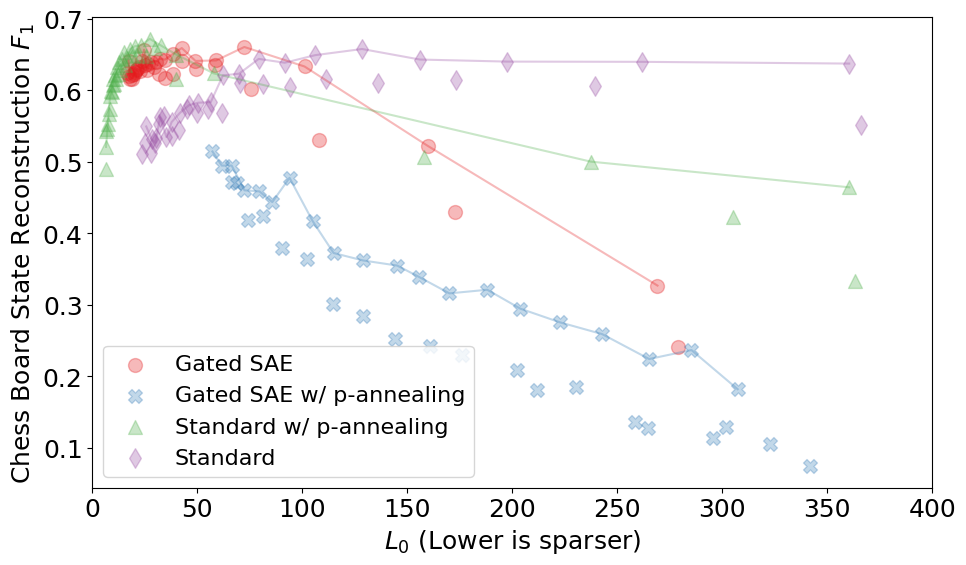

Dict size:  8192
Dict size:  8192
Dict size:  8192
Dict size:  8192


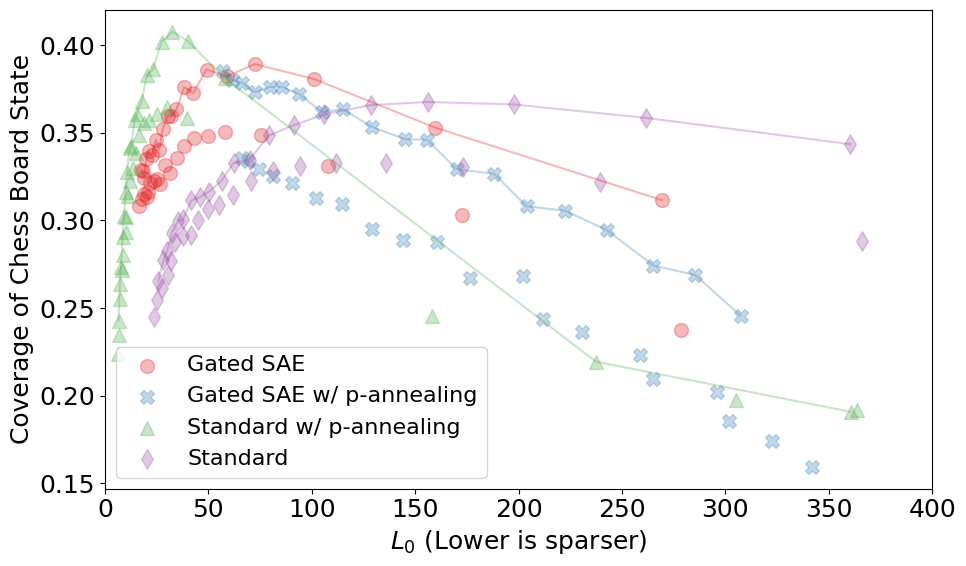

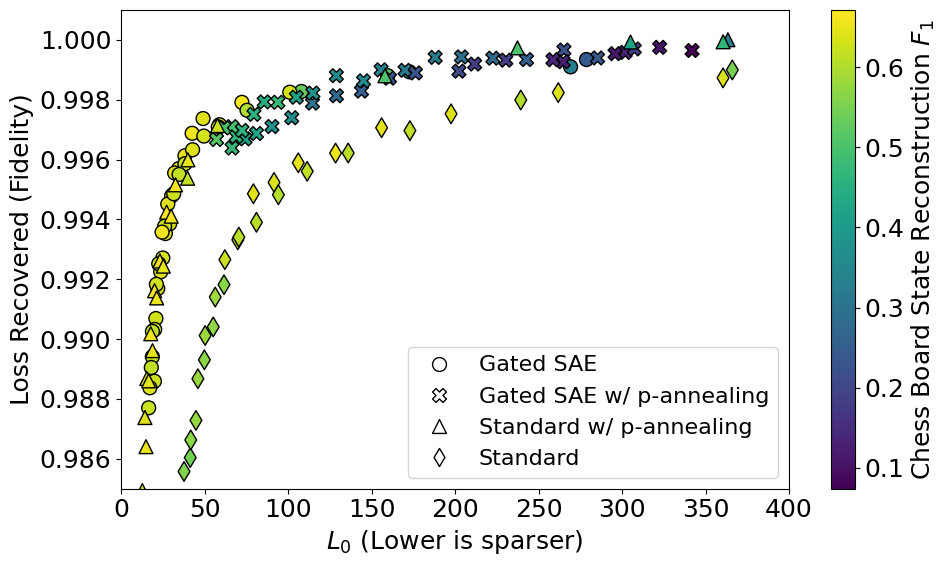

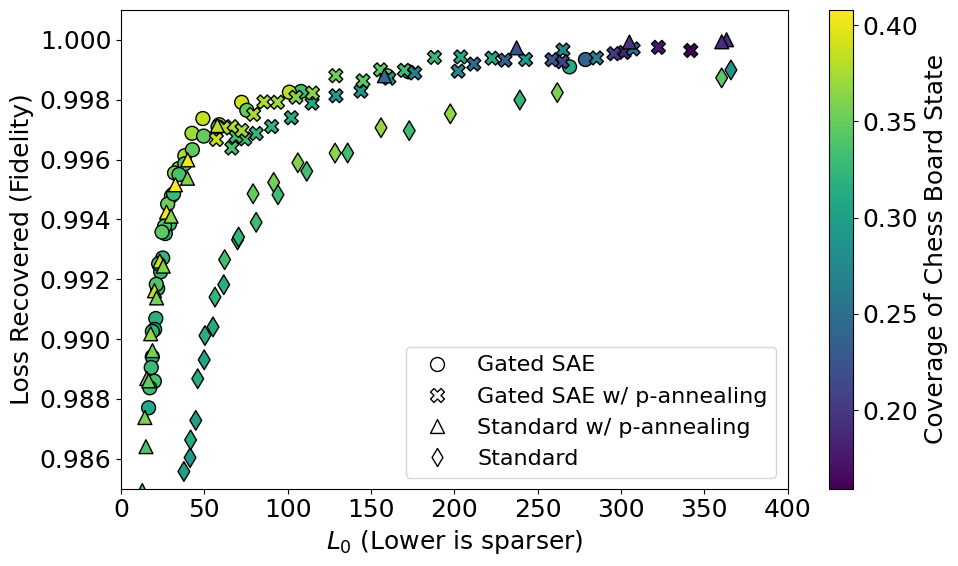

Dict size:  8192
Dict size:  8192
Dict size:  8192
Dict size:  8192


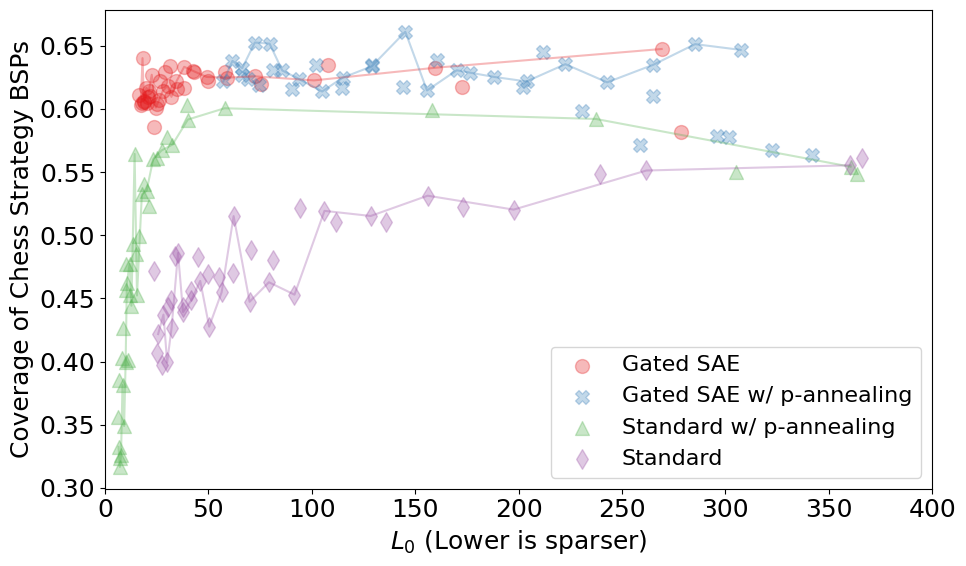

Dict size:  8192
Dict size:  8192
Dict size:  8192
Dict size:  8192


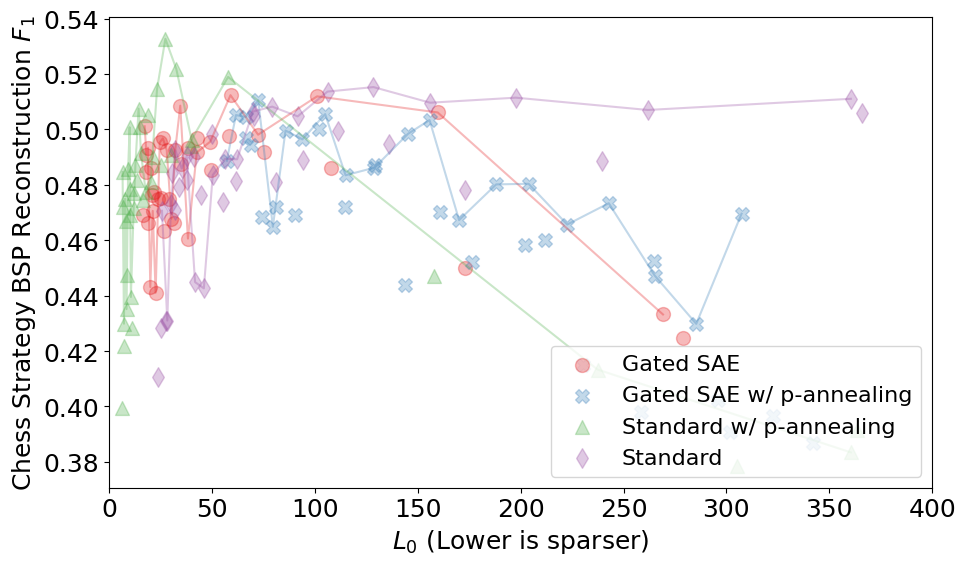

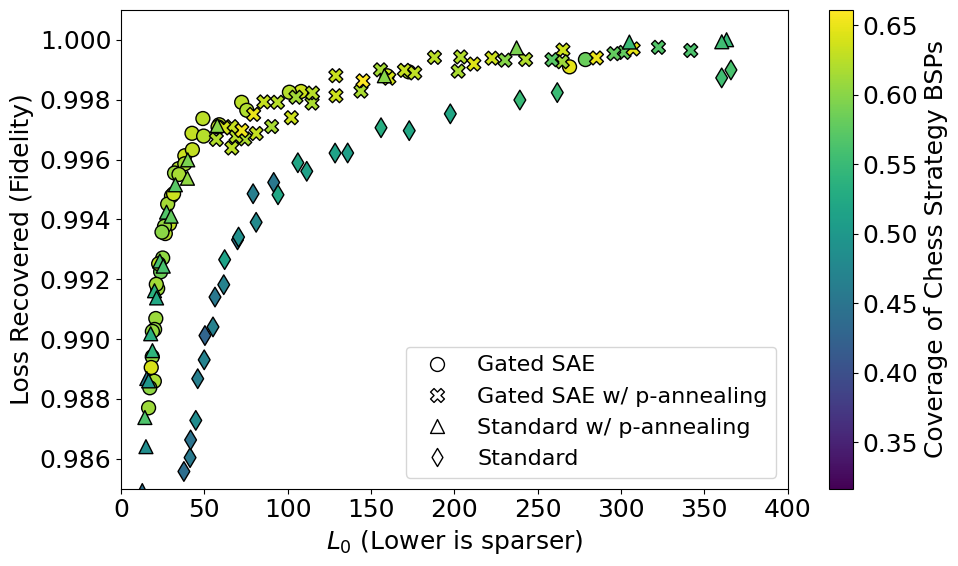

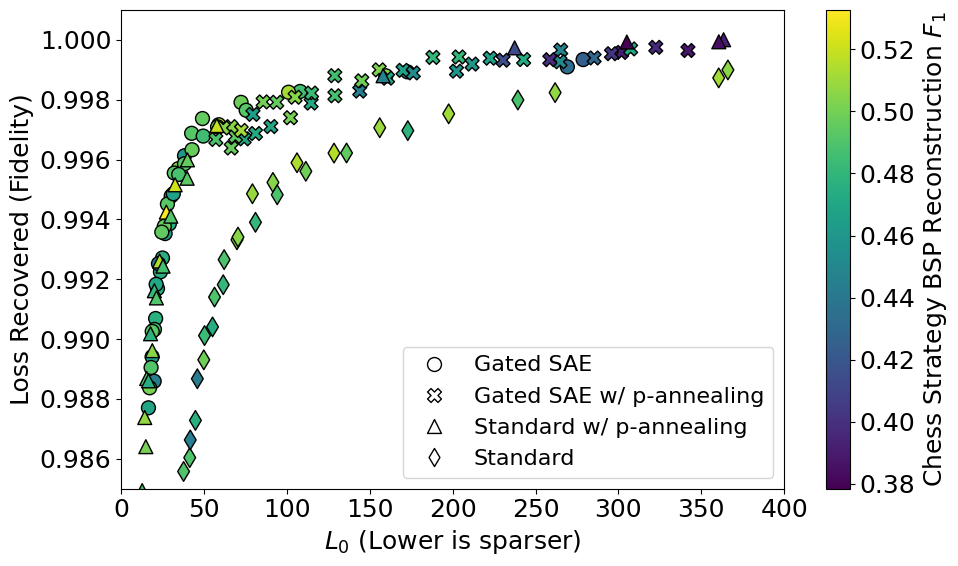

In [109]:
if not othello:
    board_reconstruction_column_name = reconstruction_key
    board_reconstruction_column_name_idx = reconstruction_key.replace(
        "best_f1_per_class", "best_idx"
    )
    coverage_column_name = coverage_key
    coverage_column_name_idx = f"{coverage_key}_idx"

    plot_l0_metric(
        board_reconstruction_column_name,
        y_label="Chess Board State Reconstruction $F_1$",
        legend_location="lower left",
        full_title="",
        output_filename="chess_2var_low_reconstruct.png",
    )
    plot_l0_metric(
        coverage_column_name,
        y_label="Coverage of Chess Board State",
        legend_location="lower left",
        full_title="",
        output_filename="chess_2var_low_coverage.png",
    )
    plot_3var_graph(
        board_reconstruction_column_name,
        board_reconstruction_column_name_idx,
        colorbar_label="Chess Board State Reconstruction $F_1$",
        output_filename="chess_3var_low_reconstruct.png",
    )
    plot_3var_graph(
        coverage_column_name,
        coverage_column_name_idx,
        colorbar_label="Coverage of Chess Board State",
        output_filename="chess_3var_low_coverage.png",
    )

    average_coverage_column = paper_average_columns[1]
    average_coverage_column_idx = paper_average_idx_columns[1]
    average_board_reconstruction_column = paper_average_columns[0]
    average_board_reconstruction_column_idx = paper_average_idx_columns[0]

    plot_l0_metric(
        average_coverage_column,
        y_label="Coverage of Chess Strategy BSPs",
        full_title="",
        output_filename="chess_2var_high_coverage.png",
    )
    plot_l0_metric(
        average_board_reconstruction_column,
        y_label="Chess Strategy BSP Reconstruction $F_1$",
        full_title="",
        output_filename="chess_2var_high_reconstruct.png",
    )
    plot_3var_graph(
        average_coverage_column,
        average_coverage_column_idx,
        colorbar_label="Coverage of Chess Strategy BSPs",
        output_filename="chess_3var_high_coverage.png",
    )
    plot_3var_graph(
        average_board_reconstruction_column,
        average_board_reconstruction_column_idx,
        colorbar_label="Chess Strategy BSP Reconstruction $F_1$",
        output_filename="chess_3var_high_reconstruct.png",
    )

In [22]:
if othello:
    board_reconstruction_column_name = (
        "games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_f1_score_per_class"
    )
    board_reconstruction_column_name_idx = (
        "games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_idx"
    )
    coverage_column_name = "games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_average_f1"
    coverage_column_name_idx = (
        "games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_average_f1_idx"
    )

    plot_l0_metric(
        board_reconstruction_column_name,
        y_label="Othello Board State Reconstruction $F_1$",
        full_title="",
        output_filename="othello_2var_reconstruct.png",
    )
    plot_l0_metric(
        coverage_column_name,
        y_label="Coverage of Othello Board State",
        full_title="",
        output_filename="othello_2var_coverage.png",
    )
    plot_3var_graph(
        board_reconstruction_column_name,
        board_reconstruction_column_name_idx,
        y_lims=(0.996, 1.0005),
        colorbar_label="Othello Board State Reconstruction $F_1$",
        output_filename="othello_3var_reconstruct.png",
    )
    plot_3var_graph(
        coverage_column_name,
        coverage_column_name_idx,
        y_lims=(0.996, 1.0005),
        colorbar_label="Coverage of Othello Board State",
        output_filename="othello_3var_coverage.png",
    )

In [39]:
from dictionary_learning.dictionary import AutoEncoder
path_to_dict_size = {}
for t_dir in df["autoencoder_path"]:
    trainer_id = t_dir.split("/")[-2]
    with open(t_dir + "/config.json", "r") as f:
        config = json.load(f)
        try:
            dict_size = config["trainer"]["dict_size"]
        except:
            # standard trainer does not store dict_size, so we have to got get it
            ae = AutoEncoder.from_pretrained(t_dir + "/ae.pt", device="cpu")
            dict_size = ae.encoder.out_features
        path_to_dict_size[t_dir] = dict_size

df["dict_size"] = df["autoencoder_path"].map(path_to_dict_size)

Uncomment the next 4 cells for exploratory analysis. They will create many plots.

In [ ]:
# for i, column_name in enumerate(paper_average_columns):
#     idx_column_name = paper_average_idx_columns[i]
#     plot_3var_graph(column_name, idx_column_name, full_title=f"Coverage {column_name}")
#     plot_l0_metric(column_name, full_title=f"Coverage {column_name}")

In [ ]:
# for i, column_name in enumerate(average_coverage_columns):
#     idx_column_name = average_coverage_idx_columns[i]
#     plot_3var_graph(column_name, idx_column_name, full_title=f"Coverage {column_name}")
#     plot_l0_metric(column_name, full_title=f"Coverage {column_name}")

In [ ]:
# for i, column_name in enumerate(board_reconstruction_columns):
#     idx_column_name = board_reconstruction_idx_columns[i]
#     plot_3var_graph(column_name, idx_column_name, full_title=f"Board Reconstruction {column_name}")
#     plot_l0_metric(column_name, full_title=f"Board Reconstruction {column_name}")

In [ ]:
# for i, column_name in enumerate(coverage_threshold_columns):
#     idx_column_name = coverage_threshold_idx_columns[i]
#     plot_3var_graph(column_name, idx_column_name, full_title=f"Coverage {column_name}")
#     plot_l0_metric(column_name, full_title=f"Coverage {column_name}")